In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23b

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dropout
- Dataset From CSV File

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
### Import Libraries

import tensorflow as tf

import os

#import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
%matplotlib inline

2022-06-21 18:02:19.534390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 18:02:19.556960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 18:02:19.557131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 20 # number of cycles to run


BATCH_SIZE = 16 # inline of Traing Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [5]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [6]:
def fn_plot_label(train_df, test_df):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [7]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [8]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


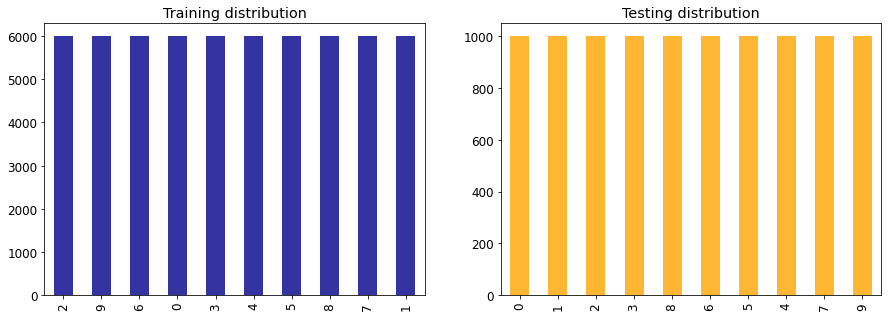

In [11]:
fn_plot_label(train_df, test_df)

In [12]:
#y_train = train_df[['label']]
#train = train_df.drop('label', axis = 1)
#X_train = train.values.reshape((train_df.shape[0], 28,28, 1))
#y_train.shape, train.shape, X_train.shape

In [13]:
#y_test = test_df[['label']]
#test = test_df.drop('label', axis = 1)
#X_test = test.values.reshape((test_df.shape[0], 28,28, 1))
#y_test.shape, test.shape, X_test.shape

## Converting to Datasets

In [14]:
def split_feature_label(row):
    
    features = tf.reshape(row[1:], [28, 28, 1])
    
    labels = row[0]
    
    return features, labels

In [15]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

2022-06-21 18:02:21.724003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 18:02:21.725073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 18:02:21.725275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 18:02:21.725400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


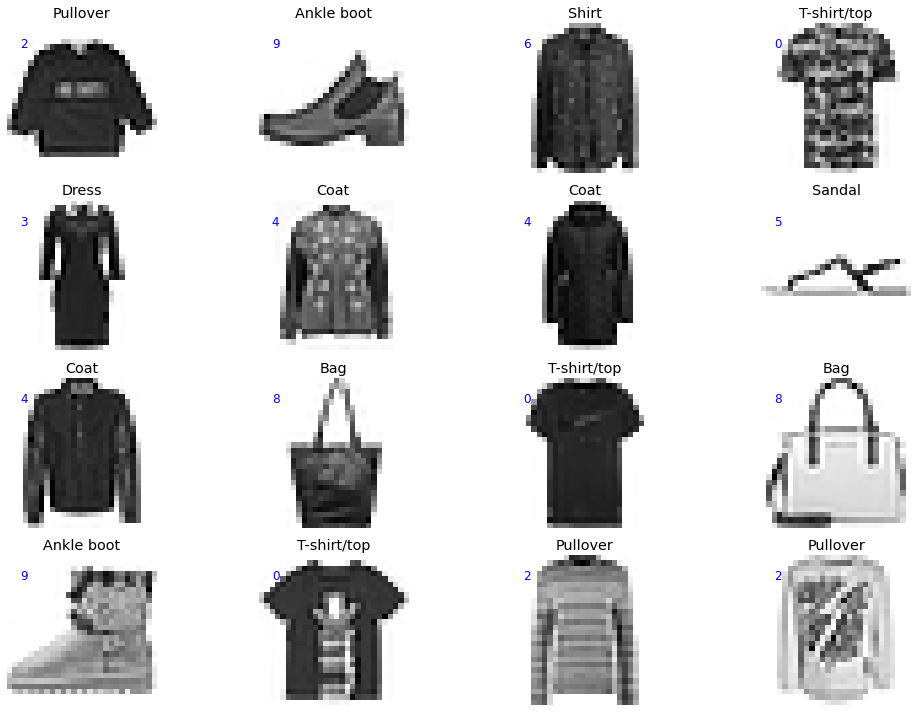

In [16]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

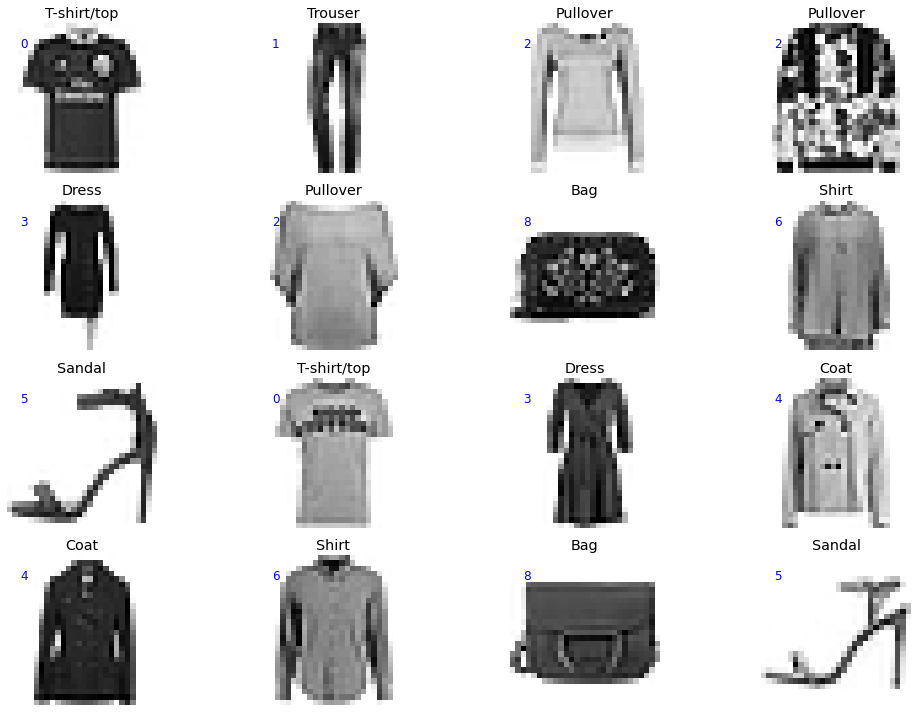

In [17]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [18]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Create the convolutional base

<img src = './images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

>tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)

>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

In [19]:
dor1 = 0.2
dor2 = 0.3
dor3 = 0.5

krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255),)

# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3),
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(28, 28, 1))) 
# Dropout 1
model.add(tf.keras.layers.Dropout(rate = dor1, seed=RANDOM_STATE))

# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu'))
# Dropout 2
model.add(tf.keras.layers.Dropout(rate = dor1, seed=RANDOM_STATE))

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) )
          
# Dropout 3
model.add(tf.keras.layers.Dropout(rate = dor2, seed=RANDOM_STATE))


In [20]:
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dropout 4
model.add(tf.keras.layers.Dropout(rate = dor3, seed=RANDOM_STATE))

# Dense 2
model.add(tf.keras.layers.Dense(10))

### Compile and train the model

In [21]:
model.compile(optimizer='adam',
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds)

Epoch 1/20


2022-06-21 18:02:25.820893: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-06-21 18:02:27.038306: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3750/3750 [==============================] - 27s 6ms/step - loss: 0.5615 - accuracy: 0.8005 - val_loss: 0.3859 - val_accuracy: 0.8627
Epoch 2/20
3750/3750 [==============================] - 23s 6ms/step - loss: 0.3777 - accuracy: 0.8658 - val_loss: 0.2926 - val_accuracy: 0.8962
Epoch 3/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.3371 - accuracy: 0.8812 - val_loss: 0.2623 - val_accuracy: 0.9068
Epoch 4/20
3750/3750 [==============================] - 23s 6ms/step - loss: 0.3150 - accuracy: 0.8880 - val_loss: 0.2554 - val_accuracy: 0.9096
Epoch 5/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.2940 - accuracy: 0.8952 - val_loss: 0.2468 - val_accuracy: 0.9131
Epoch 6/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.2847 - accuracy: 0.8987 - val_loss: 0.2675 - val_accuracy: 0.9005
Epoch 7/20
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2757 - accuracy: 0.9019 - val_loss: 0.2332 - val_accuracy: 0.9

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                        

In [23]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy
0,0.561498,0.800450,0.385866,0.8627
1,0.377748,0.865833,0.292551,0.8962
2,0.337110,0.881150,0.262336,0.9068
3,0.315029,0.888000,0.255425,0.9096
4,0.294049,0.895150,0.246762,0.9131
5,0.284689,0.898733,0.267545,0.9005
6,0.275706,0.901917,0.233197,0.9182
7,0.270006,0.903033,0.240096,0.9174
8,0.263831,0.904667,0.222391,0.9207
9,0.260881,0.908250,0.227655,0.9213


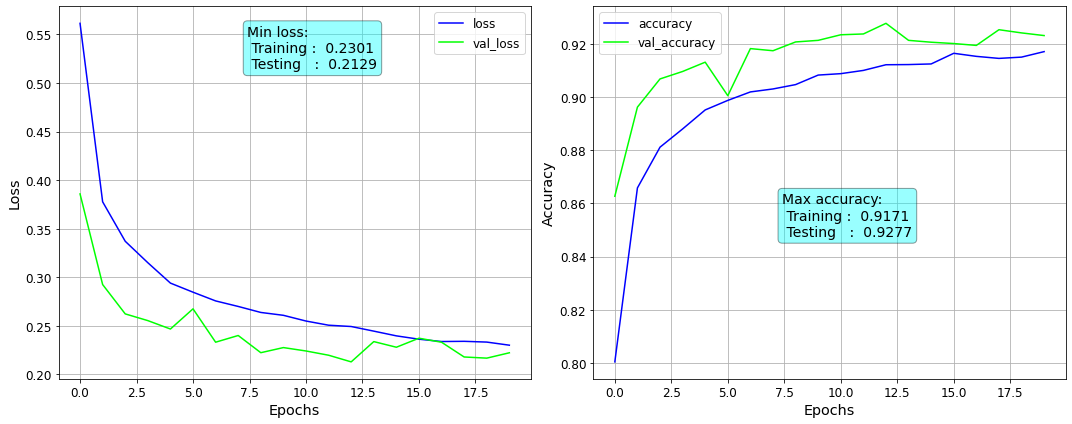

In [24]:
fn_plot_hist(res_df)

### Evaluate the model

In [25]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

625/625 - 2s - loss: 0.2223 - accuracy: 0.9231 - 2s/epoch - 3ms/step


In [26]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model.predict(test_ds)

625/625 [==============================] - 2s 2ms/step


In [27]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [28]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

Accuracy score on Test Data : 0.9231



|| |Predicted| class
|:-|:-|:-|:-|
| | |P|N|
Actual|P|TP|FN
class|N|FP|TN

In [29]:
confusion_matrix(y_test, y_pred)

array([[889,   0,  11,  24,   1,   0,  72,   0,   3,   0],
       [  0, 991,   0,   8,   0,   1,   0,   0,   0,   0],
       [ 17,   0, 834,  16,  86,   0,  46,   0,   1,   0],
       [  8,   3,   1, 946,  32,   0,   8,   0,   1,   1],
       [  0,   0,  17,  19, 930,   1,  32,   0,   1,   0],
       [  0,   0,   0,   0,   0, 967,   0,  28,   1,   4],
       [ 99,   1,  35,  43,  76,   0, 744,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1,   0, 975,   0,  24],
       [  3,   0,   1,   1,   4,   2,   1,   1, 986,   1],
       [  0,   0,   0,   0,   0,   1,   0,  30,   0, 969]])

In [30]:
test_df['y_pred'] = y_pred

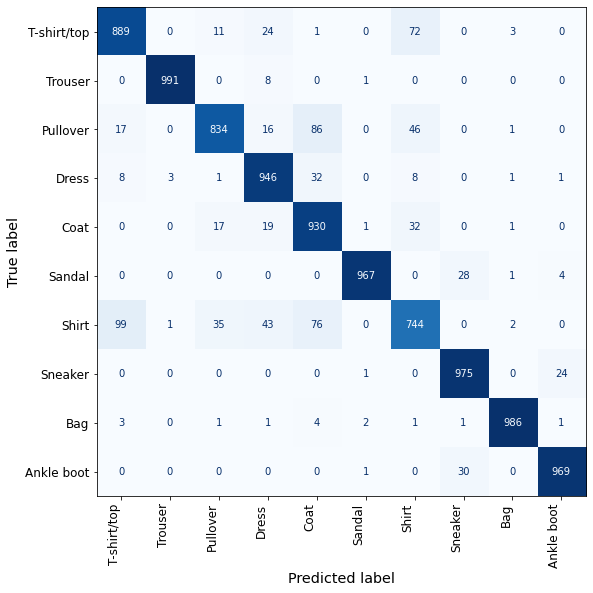

In [31]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (9,9))

disp.plot(ax = ax, cmap=CMAP, colorbar=False);

ax.set_xticklabels(class_labels.values(),rotation=90, ha='right');

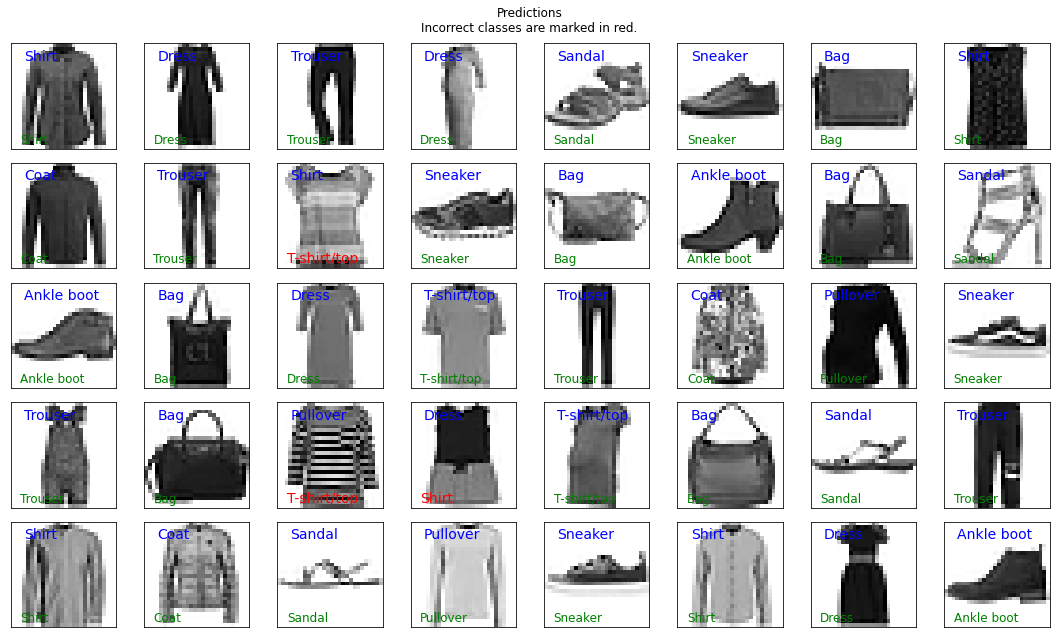

In [32]:
# Results data plot

plot_df = test_df.sample(n = 40) # Take 40 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(5, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(3, 4, class_labels[row[0]], color='blue', fontsize=14)   # add number (class) of the image
    colr = 'green'
    fntsize = 12
    
    if row[0] != row[-1]:
        colr = 'red'
        fntsize = 14
    ax.text(2, 26, class_labels[row[-1]], color=colr, fontsize=fntsize)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()